In [63]:
import time 
import datetime
from datetime import datetime

import pandas as pd
import numpy as np
import os

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import pandas_profiling 
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [64]:
df = pd.read_csv('../input/kamp2022/(approved)Kamp_Dataset.csv')
df.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
4,2020-03-04 0:00,4,798,1736,604,3.21,OK


In [65]:
Dlength = df.shape[0]
S_Step = 30
for k in df.NUM:
    if k >= 1:
        if abs(df.MELT_WEIGHT[k] -df.MELT_WEIGHT[k-1]) >  100 :

            for s in range(S_Step):
                if abs(df.MELT_WEIGHT[k - 1] - df.MELT_WEIGHT[k + s]) < 500 :
                    step =round(abs(df.MELT_WEIGHT[k - 1] - df.MELT_WEIGHT[k + s])/(s+1))
                    if df.MELT_WEIGHT[k - 1] > df.MELT_WEIGHT[k + s]:
                        df.MELT_WEIGHT[k] = df.MELT_WEIGHT[k - 1] - step
                    else:
                        df.MELT_WEIGHT[k] = df.MELT_WEIGHT[k - 1] + step
                    break

In [66]:
df['MELT_TEMP'] = (df['MELT_TEMP'] / 10) # 용해온도, 교반속도 데이터는 소수점 1 자리 생략 
df['MOTORSPEED'] = (df['MOTORSPEED'] / 10)

result_mapping = {
    "OK": 1,
    "NG": 0
}

df.loc[:, "TAG"] = df.TAG.map(result_mapping)
df['STD_DT'] = df['STD_DT'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d %H:%M'))
df.set_index('STD_DT', inplace=True)

In [67]:
feature_cols = ['MELT_TEMP', 'MOTORSPEED','MELT_WEIGHT']
label_cols = ['TAG']
cols = ['MELT_TEMP', 'MOTORSPEED','MELT_WEIGHT','TAG']

In [68]:
# melt_weight 는 종속 변수들과 상관 관계가 거의 없음. 

corr = df.corr(method='pearson')
corr

,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
NUM,1.000000,0.000188,-0.000050,0.061511,-0.000524,0.086698
MELT_TEMP,0.000188,1.000000,0.944929,0.000024,0.916295,0.310586
MOTORSPEED,-0.000050,0.944929,1.000000,0.000066,0.887813,0.264693
MELT_WEIGHT,0.061511,0.000024,0.000066,1.000000,-0.000029,-0.030665
INSP,-0.000524,0.916295,0.887813,-0.000029,1.000000,0.272580
TAG,0.086698,0.310586,0.264693,-0.030665,0.272580,1.000000


In [69]:
df1 = df[cols]
df1.head()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
STD_DT,,,,
2020-03-04,48.9,11.6,631,1
2020-03-04,43.3,7.8,609,1
2020-03-04,46.4,15.4,608,1
2020-03-04,37.9,21.2,606,1
2020-03-04,79.8,173.6,604,1


In [70]:
split_data = int(df1.shape[0] * 0.7)

train = df1[:split_data]
test = df1[split_data:]

In [71]:
print(train.shape)
print(test.shape)

(584640, 4)
(250560, 4)


In [72]:
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE

scaler = preprocessing.MinMaxScaler()

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

In [73]:
train_sc

array([[0.34541985, 0.06430155, 0.22375887, 1.        ],
       [0.23854962, 0.04323725, 0.21595745, 1.        ],
       [0.29770992, 0.08536585, 0.21560284, 1.        ],
       ...,
       [0.31679389, 0.08203991, 0.03829787, 1.        ],
       [0.1870229 , 0.03769401, 0.03794326, 1.        ],
       [0.32251908, 0.05820399, 0.03758865, 1.        ]])

In [74]:
x_train_values = train_sc[:, :-1]
y_train_values = train_sc[:, -1]

In [75]:
smote = SMOTE(random_state=42)

x_train_over, y_train_over = smote.fit_resample(x_train_values, y_train_values)
print("SMOTE 적용 전 데이터 셋: ", x_train_values.shape, y_train_values.shape)
print("SMOTE 적용 후 데이터 셋: ", x_train_over.shape, y_train_over.shape)
print("SMOTE 적용 후 LABEL 분포: \n", pd.Series(y_train_over).value_counts())

SMOTE 적용 전 데이터 셋:  (584640, 3) (584640,)
SMOTE 적용 후 데이터 셋:  (821032, 3) (821032,)
SMOTE 적용 후 LABEL 분포: 
 1.0    410516
0.0    410516
dtype: int64


In [76]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i : i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [77]:
x_train_over = pd.DataFrame(x_train_over, columns=feature_cols)
y_train_over = pd.DataFrame(y_train_over, columns=label_cols)

In [78]:
train_feature, train_label = make_dataset(x_train_over, y_train_over, 10)

In [79]:
test_sc = pd.DataFrame(test_sc, columns=cols)

In [80]:
test_feature = test_sc[feature_cols]
test_label = test_sc[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 10)
print(test_feature.shape)
print(test_label.shape)

(250550, 10, 3)
(250550, 1)


In [81]:
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.3)
print(x_train.shape)
print(x_valid.shape)

(574715, 10, 3)
(246307, 10, 3)


In [82]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [83]:
model = Sequential()
model.add(LSTM(4,
              input_shape=(train_feature.shape[1], train_feature.shape[2]),
              activation='tanh',
              return_sequences=True)
         )
model.add(LSTM(4,
              input_shape=(train_feature.shape[1], train_feature.shape[2]),
              activation='tanh',
              return_sequences=False)
         )
model.add(Dense(1, activation='sigmoid'))

In [84]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('./KAMP_MODEL.hdf5', monitor='val_loss', verbose=1,
                            save_best_only=True, mode='auto')

In [85]:
history = model.fit(x_train, y_train,
                   epochs=20,
                   batch_size=64,
                   validation_data=(x_valid, y_valid),
                   callbacks=[early_stop, checkpoint])

Epoch 1/20
8980/8980 [==============================] - 60s 6ms/step - loss: 0.3804 - accuracy: 0.7901 - val_loss: 0.3479 - val_accuracy: 0.8042

Epoch 00001: val_loss improved from inf to 0.34790, saving model to ./KAMP_MODEL.hdf5
Epoch 2/20
8980/8980 [==============================] - 55s 6ms/step - loss: 0.3457 - accuracy: 0.8077 - val_loss: 0.3457 - val_accuracy: 0.8082

Epoch 00002: val_loss improved from 0.34790 to 0.34570, saving model to ./KAMP_MODEL.hdf5
Epoch 3/20
8980/8980 [==============================] - 56s 6ms/step - loss: 0.3445 - accuracy: 0.8102 - val_loss: 0.3444 - val_accuracy: 0.8108

Epoch 00003: val_loss improved from 0.34570 to 0.34438, saving model to ./KAMP_MODEL.hdf5
Epoch 4/20
8980/8980 [==============================] - 56s 6ms/step - loss: 0.3431 - accuracy: 0.8112 - val_loss: 0.3429 - val_accuracy: 0.8123

Epoch 00004: val_loss improved from 0.34438 to 0.34291, saving model to ./KAMP_MODEL.hdf5
Epoch 5/20
8980/8980 [==============================] - 56s 

In [86]:
model.load_weights('./KAMP_MODEL.hdf5')
pred = model.predict(test_feature)

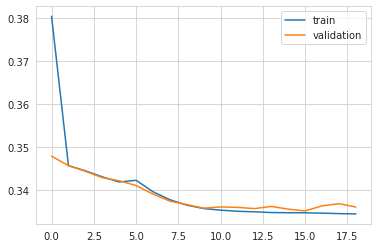

In [87]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [88]:
pred_df = pd.DataFrame(pred, columns=['TAG'])
pred_df['TAG'] = pred_df['TAG'].apply(lambda x: 1 if x >= 0.5 else 0)

In [89]:
pred_df['TAG'].value_counts()

1    181068
0     69482
Name: TAG, dtype: int64

In [90]:
classify = confusion_matrix(test_label, pred_df)
print(classify)

[[  2169    771]
 [ 67313 180297]]


In [91]:
p = precision_score(test_label, pred_df)
print("precision: %0.4f" %p)
r = recall_score(test_label, pred_df)
print("recall: %0.4f" %r)
f1 = f1_score(test_label, pred_df)
print("f1-score: %0.4f" %f1)
acc = accuracy_score(test_label, pred_df)
print("accuracy: %0.4f" %acc)

precision: 0.9957
recall: 0.7281
f1-score: 0.8412
accuracy: 0.7283
